# Загрузка Pandas и очистка данных

In [2]:
import pandas as pd
import re
import numpy as np
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler

In [97]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')


df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [72]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейкиdata.sample(5)

for i in list(df.columns):
    display(len(df[i].unique()))

#Так как уникальных значений ID_TA и URL_TA меньше 50000, данные могут содержать дубликаты

#Создание DF содежащего дубликаты по признаку ID_TA
duplicates=df[df.ID_TA.duplicated() == True].sort_values(by ='ID_TA')
duplicates

duplicates.City.unique()

#Судя по всему, данные задвоеннны по City == Madrid|City == Warsaw

difference_check = []
for i in list(duplicates.ID_TA):
    # Ниже вычисление разницы в целевой переменной для дубликатов
    dif = list(df[df.ID_TA == i].Rating)[0] - list(df[df.ID_TA == i].Rating)[1]
    difference_check.append(dif)
difference_check

duplicates.Rating.value_counts()

#Разница в целевой переменной между дублями варируется в том же диапазоне, что и переменная в срезе

df[df.ID_TA == duplicates.ID_TA.iloc[0]]

df[df.ID_TA == duplicates.ID_TA.iloc[1]]

#Судя по всему, разница между некоторыми дублями объясняется тем, что они распределены между файлами kaggle_task и main_task.

#Имеет смысл создать переменную, которая обозначит, что у строки есть дубль

### 1. Отметка дубликатов

# Помечаем новыми пизнаками превые и последние дубликаты
df['1'] = df.ID_TA.duplicated(keep='first')
df['2'] = df.ID_TA.duplicated(keep='last')

# Функция обрабатывает всмогательные столюцы и возвращает 1 для строк имеющих дубли
def duplicate(row):
    result = 0
    if row['1'] == True:
        result = 1
    elif row['2'] == True:
        result = 1
    return result

# Применение функции
df['has_duplicate'] = df.apply(duplicate, axis = 1)

# Удаление вспомогательных столбцов
df.drop(['1','2'], axis = 'columns', inplace = True)

13094

31

10732

12975

4

1574

41858

49963

49963

2

10

In [73]:
id_vc = df.groupby(['Restaurant_id']).Ranking.count()
df['id_amount'] = df.Restaurant_id.apply(lambda x: id_vc[x])

In [37]:
def reviews_date(rew, count):
    date = re.findall(r'\d\d?/\d\d?/\d+', str(rew))
    if len(date) == 0:
        return np.nan
    if count == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date[1])
    else:
        return np.nan


def reviews_text(rew, count):
    if rew == 0:
        return 'No review'
    date = re.findall(r'(\'\D+?\')', str(rew))
    if len(date) == 0:
        return 'No review'
    if count == 1:
        return date[0]
    elif len(date) > 1 and count == 2:
        return date[1]
    else:
        return np.nan


def review_to_numb(rew):
    if rew == 'No review':
        return 0
    for i in rew:
        if i in positive_list:
            return 1
        elif i in negative_list:
            return -1
        else:
            return 0


def num_years(begin, end=None):
    if end is None:
        end = dt.now()
    if begin == 0:
        return 0
    delta_time = round(((end - begin).days / 365.25), 2)
    if delta_time > 10:
        return 0
    else:
        return delta_time


def for_city(rew, city):
    if rew in city:
        return rew
    else:
        return 'others'


def cuisine_func(rew, cuisine):
    if rew == 0:
        return 0
    for i in rew:
        count = 0
        if i in cuisine:
            count += 1
    if count > 0:
        return 1
    else:
        return 0


def fill_cuisine_nan(rew, cuisine):
    if rew == 0:
        return 1
    for i in rew:
        count = 0
        if i in cuisine:
            count += 1
    if count > 0:
        return 1
    else:
        return 0

In [12]:
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,has_duplicate,id_amount
16090,id_534,Barcelona,"['Mediterranean', 'European', 'Spanish', 'Vege...",535.0,$,422.0,"[['Lovely find', 'Good choice for lunch in Bar...",/Restaurant_Review-g187497-d717389-Reviews-Res...,d717389,1,4.0,0,18
4885,id_4885,Amsterdam,"['Sushi', 'Asian', 'Vietnamese', 'Japanese', '...",2394.0,$$ - $$$,28.0,"[['Good sushi 🍥 for a good price.', 'Amaizing ...",/Restaurant_Review-g188590-d5966364-Reviews-Su...,d5966364,0,0.0,0,5
41623,id_1533,Rome,"['Italian', 'Mediterranean', 'Vegetarian Frien...",1534.0,$$ - $$$,609.0,[['Still holding its own with good food simpl....,/Restaurant_Review-g187791-d1034669-Reviews-Tr...,d1034669,1,4.0,0,13


In [38]:
df = df.drop('URL_TA', axis = 1)
df = df.drop('ID_TA', axis = 1)
df = df.drop('Restaurant_id', axis = 1)

In [15]:
df.sample(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,has_duplicate,id_amount
49967,Paris,"['French', 'European', 'Gastropub', 'Vegetaria...",1154.0,$$ - $$$,98.0,[['Cozy bistro with great food and warm servi....,1,4.5,0,8
17518,Paris,['French'],11735.0,$,24.0,"[['Poor service and average food', 'Cocktails ...",1,3.5,0,1
23061,Amsterdam,"['Fast Food', 'Middle Eastern', 'Vegetarian Fr...",1171.0,$,103.0,"[['Best falafel in the world', 'Falafel specia...",1,4.5,0,13


In [74]:
df.Reviews.fillna(df.Reviews.value_counts().index[0], inplace = True)
df.Reviews = df.Reviews.apply(lambda x: x.replace('[[], []]', ''))
df.Reviews = df.Reviews.replace('', np.nan, regex=True)
df.Reviews = df.Reviews.fillna(0)

df['reviews_text_1'] = df['Reviews'].apply(lambda x: reviews_text(x, 1))
df['reviews_text_1'] = df['reviews_text_1'].apply(lambda x: str(x).replace("'", ""))
df['reviews_text_1'] = df['reviews_text_1'].apply(lambda x: x.lower())
df['reviews_text_1'] = df['reviews_text_1'].apply(lambda x: x.split(' '))

df['reviews_text_2'] = df['Reviews'].apply(lambda x: reviews_text(x, 2))
df['reviews_text_2'] = df['reviews_text_2'].apply(lambda x: str(x).replace("'", ""))
df['reviews_text_2'] = df['reviews_text_2'].apply(lambda x: x.lower())
df['reviews_text_2'] = df['reviews_text_2'].apply(lambda x: x.split(' '))

positive = pd.read_excel('adjectives.xlsx', sheet_name = 'Sheet1', header = None)
positive = positive.apply(lambda x: x.str.lower())
positive_list = positive[0].to_list()

negative = pd.read_excel('adjectives.xlsx', sheet_name = 'Sheet2', header = None)
negative = negative.apply(lambda x: x.str.lower())
negative_list = negative[0].to_list()

df['reviews_text_1'] = df.reviews_text_1.apply(lambda x: review_to_numb(x))
df['reviews_text_2'] = df.reviews_text_2.apply(lambda x: review_to_numb(x))


df['Reviews_time_1'] = df['Reviews'].apply(lambda x: reviews_date(x, 1))
df['Reviews_time_1'] = df['Reviews_time_1'].fillna(0)
df['Reviews_time_1'] = df['Reviews_time_1'].apply(lambda x: num_years(x))

df['Reviews_time_2'] = df['Reviews'].apply(lambda x: reviews_date(x, 2))
df['Reviews_time_2'] = df['Reviews_time_2'].fillna(0)
df['Reviews_time_2'] = df['Reviews_time_2'].apply(lambda x: num_years(x))

In [75]:
scaler = StandardScaler()
test = scaler.fit_transform(np.array(df['Ranking']).reshape(-1,1))
df['Ranking'] = pd.Series(list((test)))
df['Ranking'] = df['Ranking'].apply(lambda x: x[0])

In [76]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0, inplace = True)
test_1 = scaler.fit_transform(np.array(df['Number of Reviews']).reshape(-1,1))
df['Number of Reviews'] = pd.Series(list((test_1)))
df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: x[0])

In [116]:
df['Number of Reviews']

0          4.0
1         97.0
2         28.0
3        202.0
4        162.0
         ...  
49995     79.0
49996    542.0
49997      4.0
49998     70.0
49999    260.0
Name: Number of Reviews, Length: 50000, dtype: float64

In [77]:
popular_city = df.City.value_counts()
popular_city = popular_city.loc[popular_city > 500].index.tolist()

df['City'] = df['City'].apply(lambda x: for_city(x, popular_city))
df_cities = pd.get_dummies(df['City'])
df = pd.concat([df_cities, df], axis = 1)

In [78]:
df['Cuisine Style'] = df['Cuisine Style'].str.findall(r'\w+\s*\w*\s*\w*')
df['Cuisine Style'] = df['Cuisine Style'].fillna(0)


veg = ['Vegetarian Friendly',
       'Vegan Options',
       'Gluten Free Options',
       'Healthy']
europ = ['European', 'Italian', 'French', 'Spanish',
         'British', 'Central European', 'German', 'Greek',
         'Halal', 'Czech', 'Eastern European', 'Austrian',
         'Polish', 'Hungarian', 'Scandinavian', 'Lebanese',
         'Dutch', 'Irish', 'Belgian', 'Swiss', 'Danish',
         'Swedish', 'Argentinean', 'Scottish', 'Ukrainian',
         'Norwegian', 'Slovenian', 'Russian', 'Portuguese', 'Australian',
         'Croatian', 'Singaporean', 'Romanian', 'Latvian']
mediterranean = ['Mediterranean', 'Seafood', 'Turkish', 'Delicatessen',
                 'Caribbean', 'New Zealand', 'Indonesian', 'Tunisian',
                 'Hawaiian', 'Malaysian', 'Cuban', 'Taiwanese', 'Jamaican',
                 'Sri Lankan', 'Filipino', 'Polynesian', 'Fujian']
asian = ['Asian', 'Japanese', 'Sushi', 'Chinese',  'Indian', 'Thai',
         'Vietnamese', 'Mexican',  'Korean', 'Pakistani',  'Caucasian',
         'Uzbek', 'Minority Chinese',  'Armenian', 'Central Asian',
         'Georgian', 'Israeli', 'Tibetan', 'Mongolian', 'Albanian', 'Azerbaijani']
fastfood = ['Pizza', 'Fast Food', 'Street Food']
american = ['Middle Eastern', 'American', 'Steakhouse', 'Barbecue', 'Grill', 'Gastropub',
            'South American', 'Latin', 'Central American', 'Brazilian', 'Colombian',
            'Chilean', 'Southwestern', 'Canadian', 'Native American']
african = ['African', 'Moroccan', 'Peruvian', 'Nepali', 'Balti', 'Bangladeshi', 'Persian',
           'Arabic', 'Kosher', 'Ethiopian', 'Venezuelan', 'Egyptian', 'Cajun ', 'Cambodian', 'Ecuadorean']
alco = ['Bar', 'Pub', 'Wine Bar', 'Brew Pub']
other_cusine = ['International', 'Cafe', 'Fusion', 'Soups', 'Contemporary',
                'Diner', 'Afghani', 'Creole', 'Welsh', 'Burmese', 'Yunnan', 'Salvadoran', 'Xinjiang']

df['veg'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, veg))
df['mediterranean'] = df['Cuisine Style'].apply(
    lambda x: cuisine_func(x, mediterranean))
df['asian'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, asian))
df['fastfood'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, fastfood))
df['american'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, american))
df['african'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, african))
df['europ'] = df['Cuisine Style'].apply(lambda x: fill_cuisine_nan(x, europ))
df['alco'] = df['Cuisine Style'].apply(lambda x: cuisine_func(x, alco))
df['other_cusine'] = df['Cuisine Style'].apply(
    lambda x: cuisine_func(x, other_cusine))

table = pd.pivot_table(df,
                       values=['veg', 'mediterranean', 'asian',
                               'fastfood', 'american', 'african',
                               'europ', 'alco', 'other_cusine'],
                       index='City',
                       aggfunc=np.sum)

print('veg', df.veg.sum(), '\n'
      'mediterranean', df.mediterranean.sum(), '\n'
      'asian', df.asian.sum(), '\n'
      'fastfood', df.fastfood.sum(), '\n'
      'american',  df.american.sum(), '\n'
      'african', df.african.sum(), '\n'
      'europ', df.europ.sum(), '\n'
      'alco', df.alco.sum(), '\n'
      'other_cusine', df.other_cusine.sum())

veg 14592 
mediterranean 2177 
asian 3273 
fastfood 1795 
american 1607 
african 265 
europ 22306 
alco 2018 
other_cusine 1967


In [93]:
def fix_price_range(x):
    if x == None:
        return np.nan
    if x == '$':
        return 1
    if x == '$$ - $$$':
        return 2.5
    if x == '$$$$':
        return 4

In [80]:
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)
df.columns

Index(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Krakow',
       'Lisbon', 'London', 'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto',
       'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich',
       'others', 'Ranking', 'Price Range', 'Number of Reviews', 'sample',
       'Rating', 'has_duplicate', 'id_amount', 'reviews_text_1',
       'reviews_text_2', 'Reviews_time_1', 'Reviews_time_2', 'veg',
       'mediterranean', 'asian', 'fastfood', 'american', 'african', 'europ',
       'alco', 'other_cusine'],
      dtype='object')

In [101]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [104]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    # Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    df_output['Cuisine Style'].fillna('European', inplace=True)
    
    citys = df_output.City.value_counts()
    #df_output.City = df_output.City.apply(lambda x: x if citys[x]>100 else np.nan)
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True) #, 'Price Range'
    
    def fix_price_range(x):
        if x == None:
            return np.nan
        if x == '$':
            return 1
        if x == '$$ - $$$':
            return 2.5
        if x == '$$$$':
            return 4
    
    df_output['Price Range'] = df_output['Price Range'].apply(lambda x: fix_price_range(x))
    df_output['Price Range'] = df_output['Price Range'].fillna(round(df_output['Price Range'].mean(), 1))
        
    # ################### 4. Feature Engineering ####################################################
    cuisine = set()
    
    df_output['Cuisine Style'] = df_output['Cuisine Style'].str.findall('\w+\s*\w*\s*\w*')

    cuisines = set()  # создаём пустое множество для хранения уникальных значений кухонь
    for cuisinesList in df_output['Cuisine Style']:
        for cuisine in cuisinesList:
            cuisines.add(cuisine)


    def find_item(cell):
        if item in cell:
            return 1
        return 0


    for item in cuisines:
        df_output[item] = df_output['Cuisine Style'].apply(find_item)

    # Добавляем признак - количество кухонь
    df_output['Cuisine Count'] = df_output['Cuisine Style'].apply(lambda x: len(x))
    
    
    df_output.Reviews.fillna(df_output.Reviews.value_counts().index[0], inplace = True)
    df_output.Reviews = df_output.Reviews.apply(lambda x: x.replace('[[], []]', ''))
    df_output.Reviews = df_output.Reviews.replace('', np.nan, regex=True)
    df_output.Reviews = df_output.Reviews.fillna(0)

    df_output['reviews_text_1'] = df_output['Reviews'].apply(lambda x: reviews_text(x, 1))
    df_output['reviews_text_1'] = df_output['reviews_text_1'].apply(lambda x: str(x).replace("'", ""))
    df_output['reviews_text_1'] = df_output['reviews_text_1'].apply(lambda x: x.lower())
    df_output['reviews_text_1'] = df_output['reviews_text_1'].apply(lambda x: x.split(' '))

    df_output['reviews_text_2'] = df_output['Reviews'].apply(lambda x: reviews_text(x, 2))
    df_output['reviews_text_2'] = df_output['reviews_text_2'].apply(lambda x: str(x).replace("'", ""))
    df_output['reviews_text_2'] = df_output['reviews_text_2'].apply(lambda x: x.lower())
    df_output['reviews_text_2'] = df_output['reviews_text_2'].apply(lambda x: x.split(' '))

    positive = pd.read_excel('adjectives.xlsx', sheet_name = 'Sheet1', header = None)
    positive = positive.apply(lambda x: x.str.lower())
    positive_list = positive[0].to_list()

    negative = pd.read_excel('adjectives.xlsx', sheet_name = 'Sheet2', header = None)
    negative = negative.apply(lambda x: x.str.lower())
    negative_list = negative[0].to_list()

    df_output['reviews_text_1'] = df_output.reviews_text_1.apply(lambda x: review_to_numb(x))
    df_output['reviews_text_2'] = df_output.reviews_text_2.apply(lambda x: review_to_numb(x))


    df_output['Reviews_time_1'] = df_output['Reviews'].apply(lambda x: reviews_date(x, 1))
    df_output['Reviews_time_1'] = df_output['Reviews_time_1'].fillna(0)
    df_output['Reviews_time_1'] = df_output['Reviews_time_1'].apply(lambda x: num_years(x))

    df_output['Reviews_time_2'] = df_output['Reviews'].apply(lambda x: reviews_date(x, 2))
    df_output['Reviews_time_2'] = df_output['Reviews_time_2'].fillna(0)
    df_output['Reviews_time_2'] = df_output['Reviews_time_2'].apply(lambda x: num_years(x))
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

In [105]:
df_preproc = preproc_data(data)
df_preproc.sample(5)

,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,Turkish,Afghani,Gluten Free Options,South American,Caribbean,Cuisine Count,reviews_text_1,reviews_text_2,Reviews_time_1,Reviews_time_2
46947,3972.0,2.5,207.0,1,3.5,0,0,0,0,0,...,0,0,0,0,0,2,0,0,3.09,3.14
32686,2472.0,2.5,2.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0.00,0.00
17986,2530.0,2.5,242.0,1,4.0,0,0,0,0,0,...,0,0,1,0,0,4,1,0,3.03,3.22
41049,4493.0,1.0,113.0,1,3.0,0,0,0,0,0,...,0,0,0,0,0,3,0,1,3.89,3.48
6017,23.0,2.5,1182.0,0,0.0,0,0,0,0,0,...,0,0,1,0,0,7,1,1,2.95,2.98


In [113]:
def round_of_rating(number):
    return np.round(number * 2) / 2

In [114]:
RANDOM_SEED = 42
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values    # наш таргет
X = train_data.drop(['Rating'], axis=1)
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = round_of_rating(y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


MAE: 0.1786875


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [108]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20565624999999998


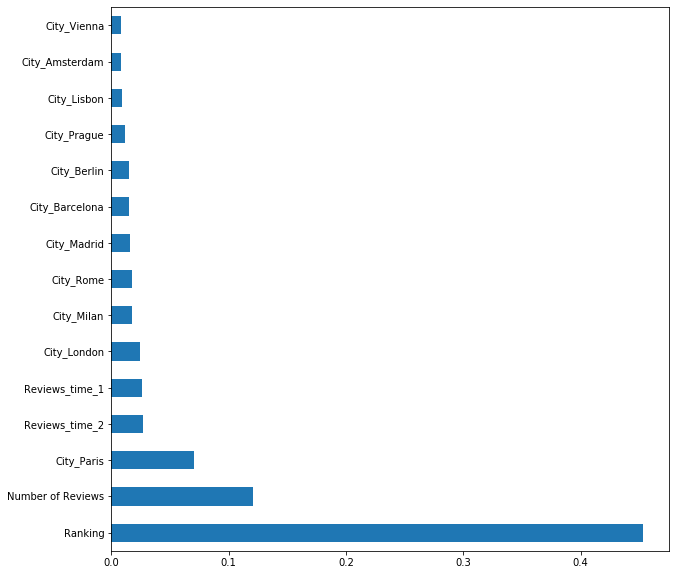

In [115]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [61]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [62]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [63]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [65]:
X_train['Ranking'] = X_train['Ranking'].fillna(X_train.Ranking.mean())
X_train['Number of Reviews'] = X_train['Number of Reviews'].fillna(0)

C:\Users\stepn\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\stepn\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
X_test['Ranking'] = X_test['Ranking'].fillna(X_test.Ranking.mean())
X_test['Number of Reviews'] = X_test['Number of Reviews'].fillna(0)

C:\Users\stepn\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\stepn\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
X_train.columns

Index(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Brussels', 'Budapest',
       'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg', 'Krakow',
       'Lisbon', 'London', 'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto',
       'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich',
       'others', 'Ranking', 'Price Range', 'Number of Reviews', 'sample',
       'has_duplicate', 'id_amount', 'reviews_text_1', 'reviews_text_2',
       'Reviews_time_1', 'Reviews_time_2', 'veg', 'mediterranean', 'asian',
       'fastfood', 'american', 'african', 'europ', 'alco', 'other_cusine'],
      dtype='object')

# Создаём, обучаем и тестируем модель

In [28]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [68]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [53]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17238199999999998


In [58]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

ValueError: Length of passed values is 46, index implies 49.